<a href="https://colab.research.google.com/github/me-dibs/intern-project/blob/main/1_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Description:

In this notebook we preprocess our dataset "normal_tissue.tsv" available under "Normal Tissue Data" here:
https://v22.proteinatlas.org/about/download

After necessary preprocessing we load it to our Hugging Face dataset repository for ease during finetuning

Direct access to the processed dataset in Hugging Face:
https://huggingface.co/datasets/autumnal05/transformed_normal_tissue_4k

#1. Installing the required packages

In [6]:
! pip install datasets
! pip install huggingface_hub
! pip install pandas

  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached aiohttp-3.11.2-cp312-cp312-win_amd64.whl.metadata (8.0 kB)
  Using cached aiohappyeyeballs-2.4.3-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached frozenlist-1.5.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached multidict-6.1.0-cp312-cp312-win_amd64.whl.metadata (5.1 kB)
  Using cached yarl-1.17.1-cp312-cp312-win_amd64.whl.metadata (66 kB)
Using cached datasets-3.1.0-py3-none-any.whl (480 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
Using cached 

In [7]:
import pandas as pd
from datasets import Dataset

d:\ISI PROJECT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#In case of Llama 2, the following prompt template is used for the chat models

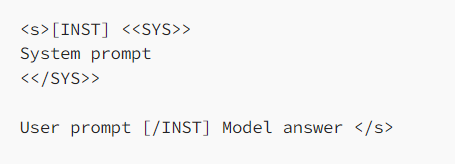

System Prompt (optional) to guide the model


User prompt or Human prompt(required) to give the instruction


Model Answer or Assistant prompt (required)

#So we write a function to convert the data to natural language in the form used by Llama 2 chatbot

In [9]:
#loading the dataset which is a tsv file
df = pd.read_csv('normal_tissue.tsv', sep='\t')
df = df.head(4000)#using the first 4000 rows

In [11]:
#Function to transform the dataset into the desired format
def transform_by_tissue(df, gene_name, tissue):
    #Filtering the data for the specific gene and tissue
    filtered_data = df[(df['Gene name'] == gene_name) & (df['Tissue'] == tissue)]

    #Checking if the filtered data is not empty
    if filtered_data.empty:
        return None  # or return a suitable default value

    #Constructing the 'Human' prompt
    human_text = f"What is the expression profile for {gene_name} in the {tissue}?"

    #Constructing the 'Assistant' response based on all matching rows
    assistant_parts = []
    for _, row in filtered_data.iterrows():
        assistant_parts.append(f"The expression level is {row['Level'].lower()} in {row['Cell type']} with reliability of {row['Reliability']}.")

    assistant_text = f"The expression level of gene {gene_name} with Ensembl gene identifier {filtered_data.iloc[0]['Gene']} is as follows: " + " ".join(assistant_parts) + " The reliability is with respect to immunohistochemistry using tissue micro arrays."

    #Returning the formatted conversation
    return f"<s>[INST] {human_text} [/INST] {assistant_text} </s>"


In [12]:
#Generating dataset using unique gene names and tissues
transformed_texts = []
for gene_name in df['Gene name'].unique():
    for tissue in df[df['Gene name'] == gene_name]['Tissue'].unique():
        transformed_text = transform_by_tissue(df, gene_name, tissue)
        if transformed_text:  #Check if transformed_text is not None
            transformed_texts.append(transformed_text)

In [13]:
#Savingthe transformed data
pd.DataFrame({'transformed_text': transformed_texts}).to_json('transformed_dataset_4k.json', orient='records', lines=True)

In [14]:
df = pd.read_json('transformed_dataset_4k.json', lines=True)
df= df.head(2000)#dataset to have only 2000 entries
dataset = Dataset.from_pandas(df)


In [15]:
#checking the format of our dataset
print(dataset)

Dataset({
    features: ['transformed_text'],
    num_rows: 2000
})


In [16]:
dataset.push_to_hub("autumnal05/transformed_normal_tissue_2k")#use dataset repository name in Hugging Face

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
d:\ISI PROJECT\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\risha\.cache\huggingface\hub\datasets--autumnal05--transformed_normal_tissue_2k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/datasets/autumnal05/transformed_normal_tissue_2k/commit/82e51d99f11886621804d8c665aa2d82df01f928', commit_message='Upload dataset', commit_description='', oid='82e51d99f11886621804d8c665aa2d82df01f928', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/autumnal05/transformed_normal_tissue_2k', endpoint='https://huggingface.co', repo_type='dataset', repo_id='autumnal05/transformed_normal_tissue_2k'), pr_revision=None, pr_num=None)

In [17]:
dataset.push_to_hub("Sukanya123/transformed_normal_tissue_2k")#use dataset repository name in Hugging Face

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]


HfHubHTTPError: (Request ID: Root=1-6739e72c-3010bb2821bc7c8a08775353;387b488f-4e6b-4c24-91f6-e32ac831bbf2)

403 Forbidden: You have read access but not the required permissions for this operation.
Cannot access content at: https://huggingface.co/datasets/Sukanya123/transformed_normal_tissue_2k.git/info/lfs/objects/batch.
Make sure your token has the correct permissions.